In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend, parallel
import pandas as pd

from change_v_a_and_bound_utils import psiam_tied_data_gen_wrapper_bound_and_v_a_change

# params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(100e3)
dt = 1e-4

N_print = int(100e3/10)
N_params = 10

bound_step_size = 0.5
new_V_A = 1.4

# abl,ild,stim,led times

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate

In [4]:
bound_change_results_dict = {}
for i in range(N_params):
    new_bound = theta_E - i * bound_step_size

    with parallel_backend('threading', n_jobs=-1):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_wrapper_bound_and_v_a_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E,\
                                                               t_A_aff, t_E_aff, t_motor, L,t_stim_and_led_tuple, new_bound, new_V_A, iter_num, \
                                                                N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new bound: {new_bound}, ')

    bound_change_results_dict[i] = {'results': sim_results, 'new_bound':  new_bound, 'new_V_A': new_V_A }

os id: 2685377, In iter_num: 0, ABL: 40, ILD: -1.0, t_stim: 1.00103301002761
os id: 2685377, In iter_num: 10000, ABL: 60, ILD: 4.0, t_stim: 0.224071335735351
os id: 2685377, In iter_num: 20000, ABL: 20, ILD: -2.0, t_stim: 1.00350133763384
os id: 2685377, In iter_num: 30000, ABL: 60, ILD: 1.0, t_stim: 0.543822692562188
os id: 2685377, In iter_num: 40000, ABL: 20, ILD: -2.0, t_stim: 1.55447836701275
os id: 2685377, In iter_num: 50000, ABL: 20, ILD: 1.0, t_stim: 0.567955203506233
os id: 2685377, In iter_num: 60000, ABL: 40, ILD: -1.0, t_stim: 0.870680313519076
os id: 2685377, In iter_num: 70000, ABL: 60, ILD: 1.0, t_stim: 0.601141528950204
os id: 2685377, In iter_num: 80000, ABL: 60, ILD: 8.0, t_stim: 0.432933114309755
os id: 2685377, In iter_num: 90000, ABL: 40, ILD: -4.0, t_stim: 0.879561749297735
V_A: 1.1, new bound: 40.5, 
os id: 2685377, In iter_num: 0, ABL: 40, ILD: 4.0, t_stim: 0.571200537108074
os id: 2685377, In iter_num: 10000, ABL: 20, ILD: -16.0, t_stim: 0.884509468055008
os i

# grand accuracy, rt vs param

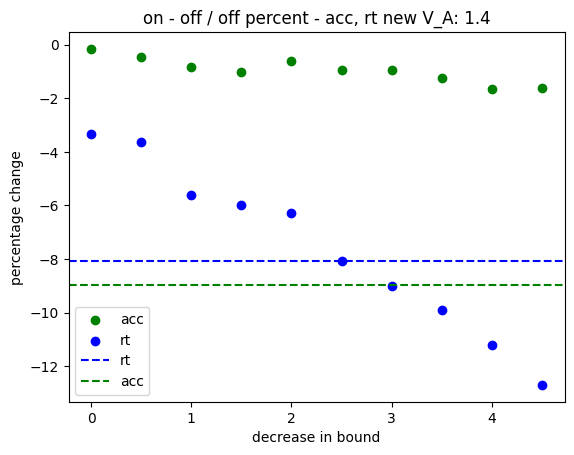

In [6]:
mean_vs_param_on_acc = np.zeros((N_params))
mean_vs_param_off_acc = np.zeros((N_params))


mean_vs_param_on_rt = np.zeros((N_params))
mean_vs_param_off_rt = np.zeros((N_params))



for i in range(N_params):
    results =  bound_change_results_dict[i]['results']
    
    on_total = 0
    on_correct = 0

    off_total = 0
    off_correct = 0

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                on_correct += 1

        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_total += 1
            if (res['ILD'] > 0 and res['choice'] == 1) or (res['ILD'] < 0 and res['choice'] == -1):
                off_correct += 1

    mean_vs_param_on_acc[i] = on_correct / on_total
    mean_vs_param_off_acc[i] = off_correct / off_total





for i in range(N_params):
    results =  bound_change_results_dict[i]['results']

    on_rt = []
    off_rt = []

    for res in results:
        if res['is_LED_trial'] and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            on_rt.append(res['rt'] - res['t_stim'])
        elif (not res['is_LED_trial']) and res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            off_rt.append(res['rt'] - res['t_stim'])

    mean_vs_param_on_rt[i] = np.mean(on_rt)
    mean_vs_param_off_rt[i] = np.mean(off_rt)

plt.scatter([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_acc - mean_vs_param_off_acc)/mean_vs_param_off_acc, label='acc', color='g')
plt.scatter([i * bound_step_size for i in range(N_params)], 100*(mean_vs_param_on_rt - mean_vs_param_off_rt)/mean_vs_param_off_rt, label='rt', color='b')

plt.axhline(-8.0781, label='rt', color='b', linestyle='--')
plt.axhline(-8.9482, label='acc', color='g', linestyle='--')

plt.xlabel('decrease in bound')
plt.ylabel('percentage change')
plt.legend()
plt.title(f'on - off / off percent - acc, rt new V_A: {new_V_A}');


# metric 1 - % of aborts

In [9]:
for i in range(N_params):
    new_bound = bound_change_results_dict[i]['new_bound']
    new_V_A = bound_change_results_dict[i]['new_V_A']
    sim_results = bound_change_results_dict[i]['results']

    sim_results_led_on = [res for res in sim_results if res['is_LED_trial'] == 1]
    sim_results_led_off = [res for res in sim_results if res['is_LED_trial'] == 0]

    aborts_led_on = [res for res in sim_results_led_on if res['rt'] < res['t_stim'] and res['rt'] > res['t_led']]
    aborts_led_off = [res for res in sim_results_led_off if res['rt'] < res['t_stim'] and res['rt'] > res['t_led']]

    print(f'new bound: {new_bound}, new V_A: {new_V_A}')
    frac_of_aborts_led_on = len(aborts_led_on) / len(sim_results_led_on)
    frac_of_aborts_led_off = len(aborts_led_off) / len(sim_results_led_off)

    increase_in_aborts_relative_to_off = 100*(frac_of_aborts_led_on - frac_of_aborts_led_off) / frac_of_aborts_led_off
    print(f'led on frac= {100*frac_of_aborts_led_on:.2f}, led off frac = {100*frac_of_aborts_led_off:.2f},% aborts change = {increase_in_aborts_relative_to_off:.2f}%')



new bound: 40.5, new V_A: 1.4
led on frac= 14.08, led off frac = 11.12,% aborts change = 26.60%
new bound: 40.0, new V_A: 1.4
led on frac= 13.85, led off frac = 11.01,% aborts change = 25.82%
new bound: 39.5, new V_A: 1.4
led on frac= 13.38, led off frac = 11.08,% aborts change = 20.71%
new bound: 39.0, new V_A: 1.4
led on frac= 13.74, led off frac = 11.12,% aborts change = 23.56%
new bound: 38.5, new V_A: 1.4
led on frac= 13.54, led off frac = 11.04,% aborts change = 22.71%
new bound: 38.0, new V_A: 1.4
led on frac= 13.52, led off frac = 10.85,% aborts change = 24.65%
new bound: 37.5, new V_A: 1.4
led on frac= 13.63, led off frac = 11.14,% aborts change = 22.39%
new bound: 37.0, new V_A: 1.4
led on frac= 13.91, led off frac = 11.01,% aborts change = 26.34%
new bound: 36.5, new V_A: 1.4
led on frac= 13.70, led off frac = 10.94,% aborts change = 25.18%
new bound: 36.0, new V_A: 1.4
led on frac= 13.72, led off frac = 11.01,% aborts change = 24.57%


# metric - 2 - psycho

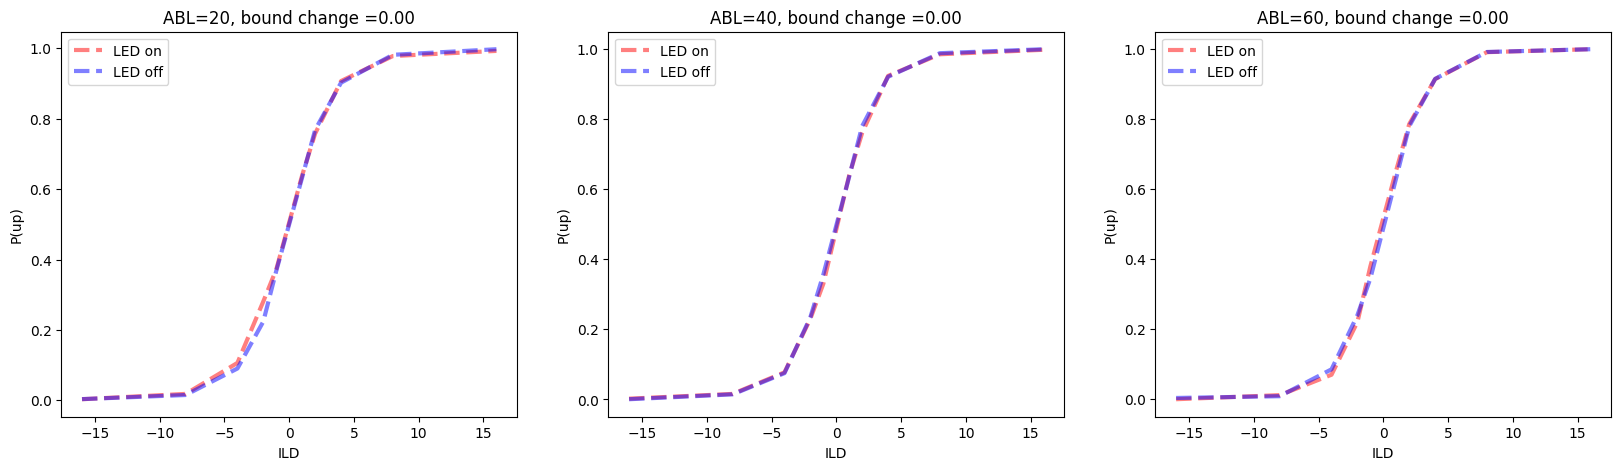

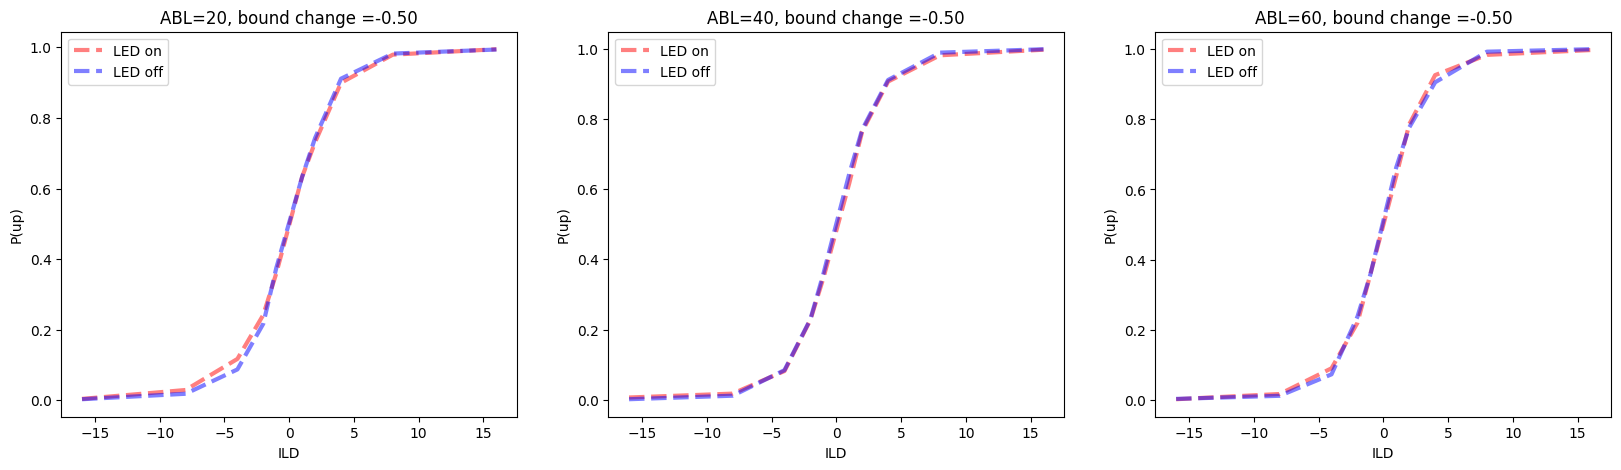

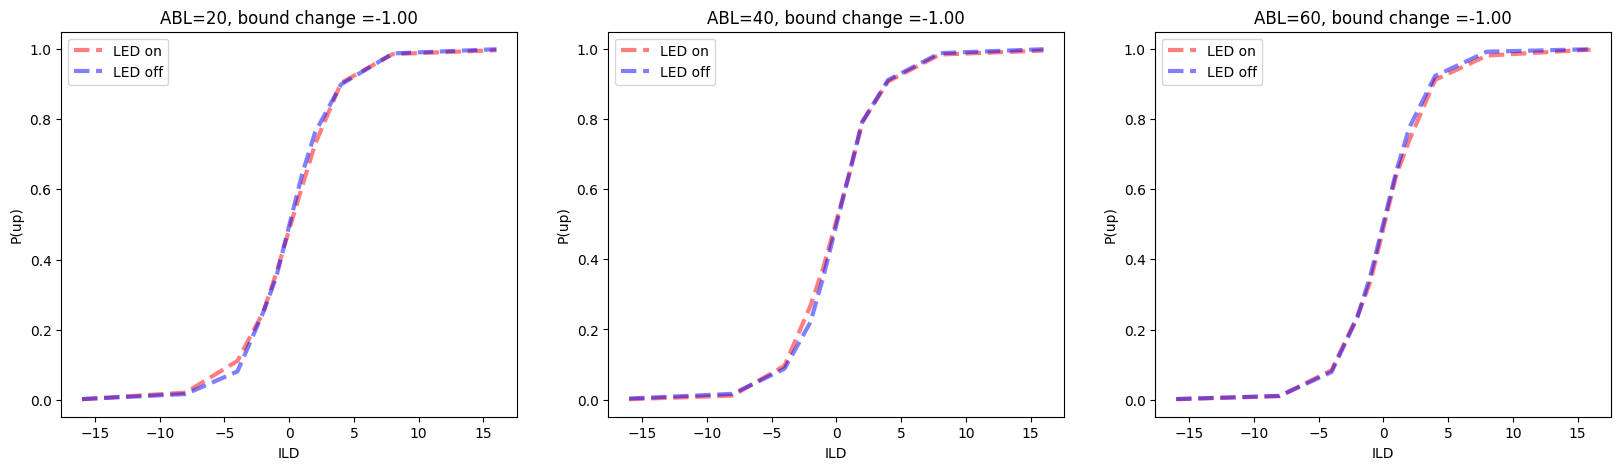

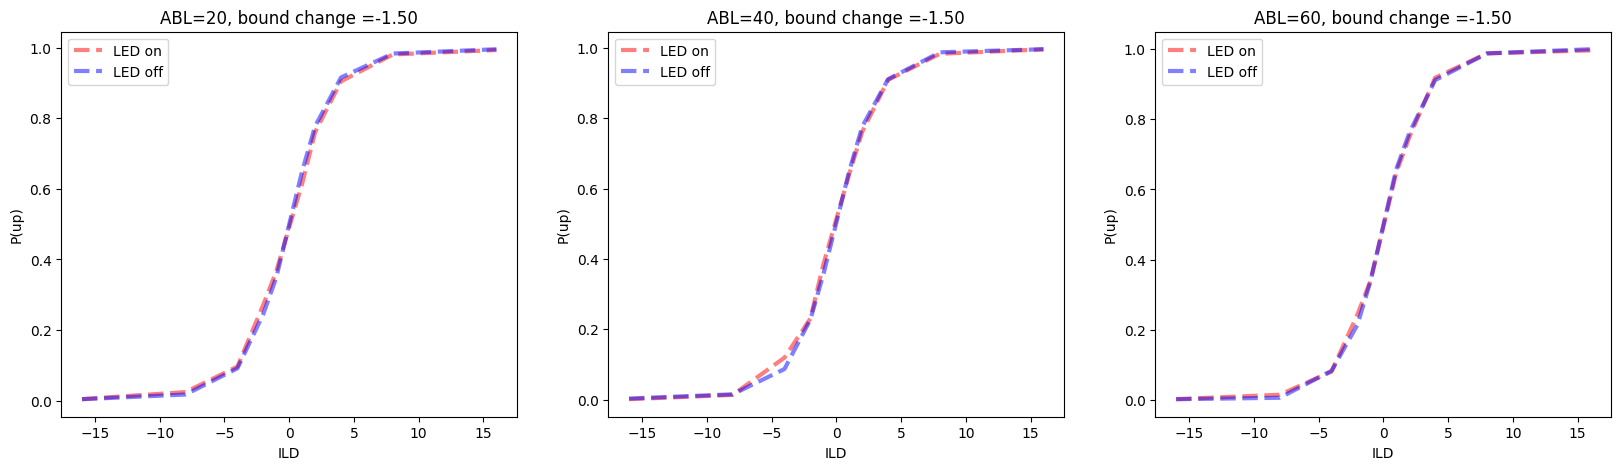

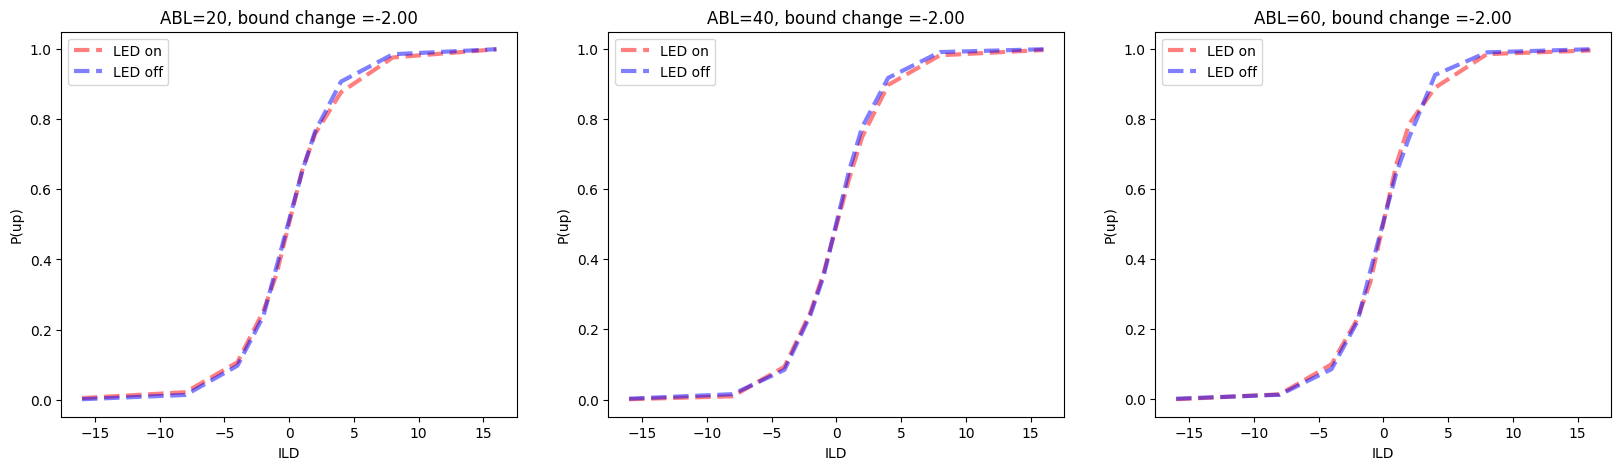

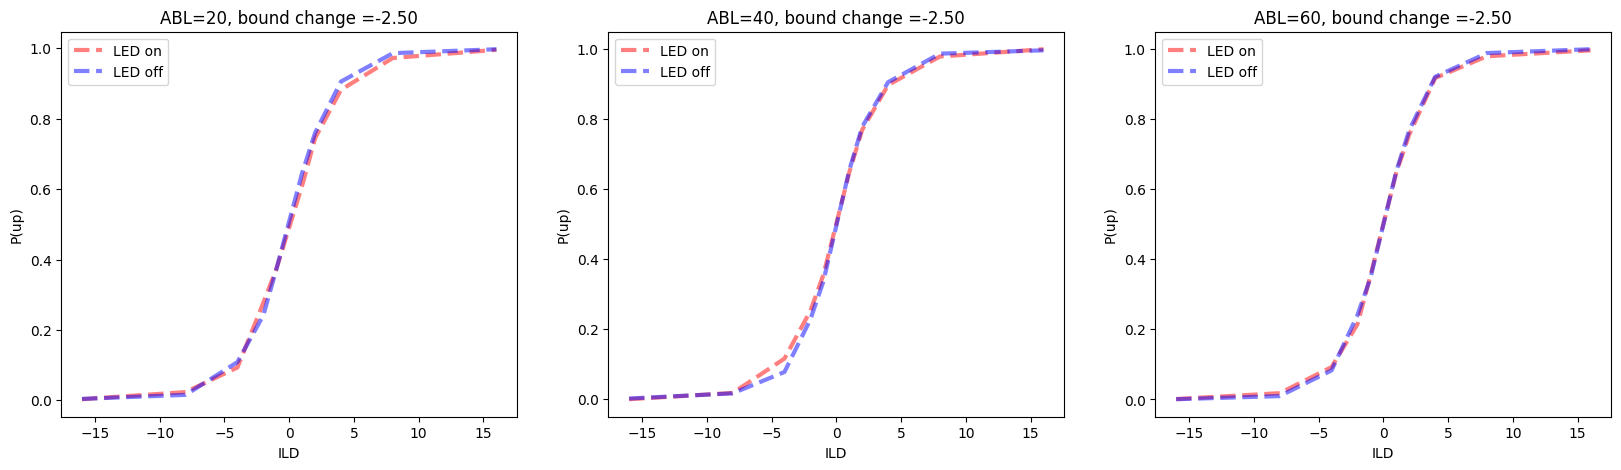

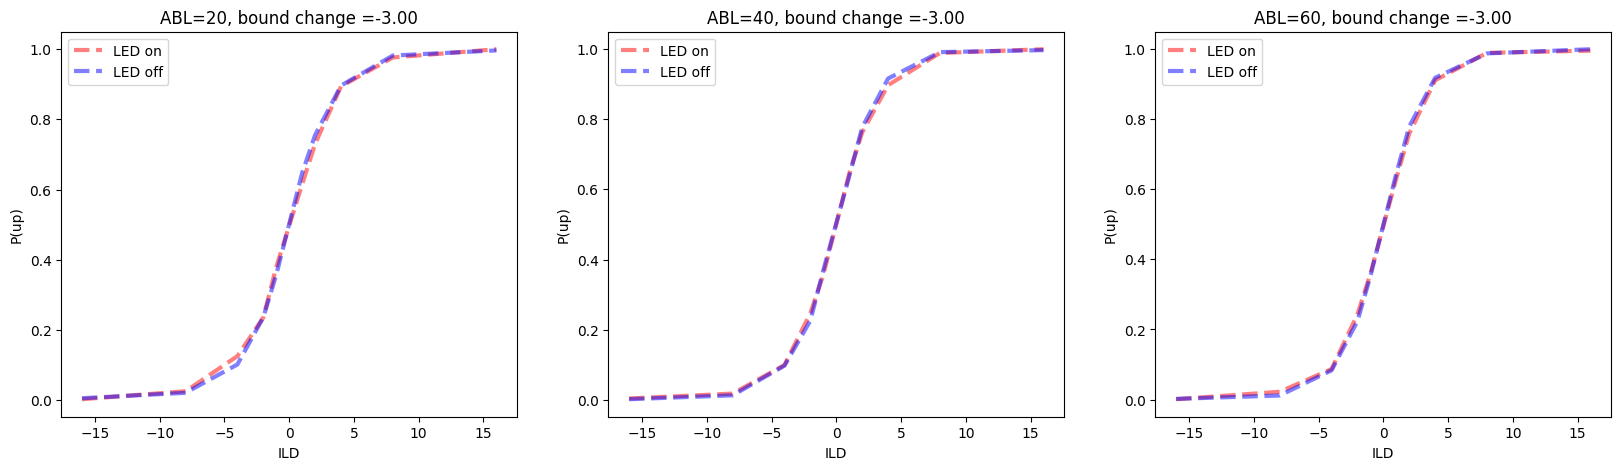

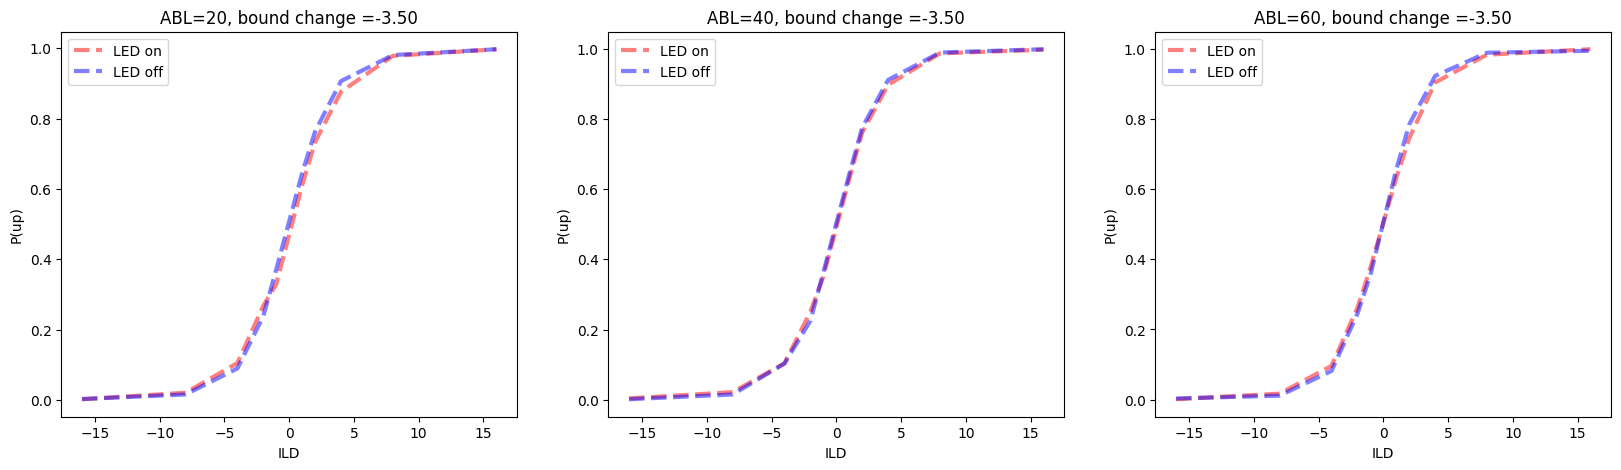

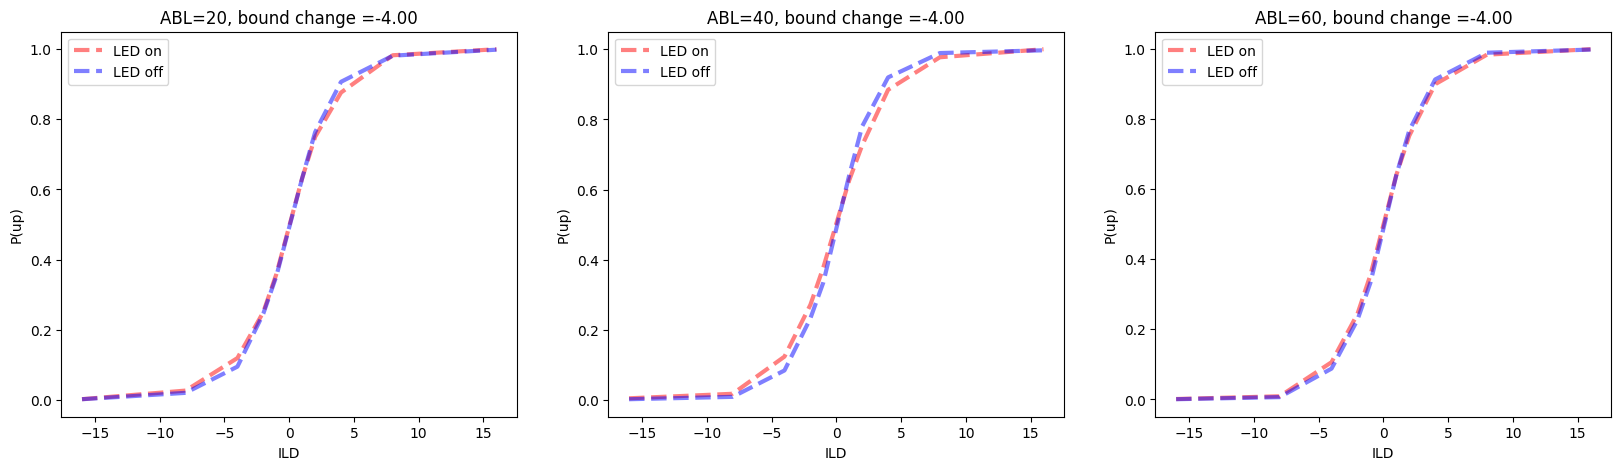

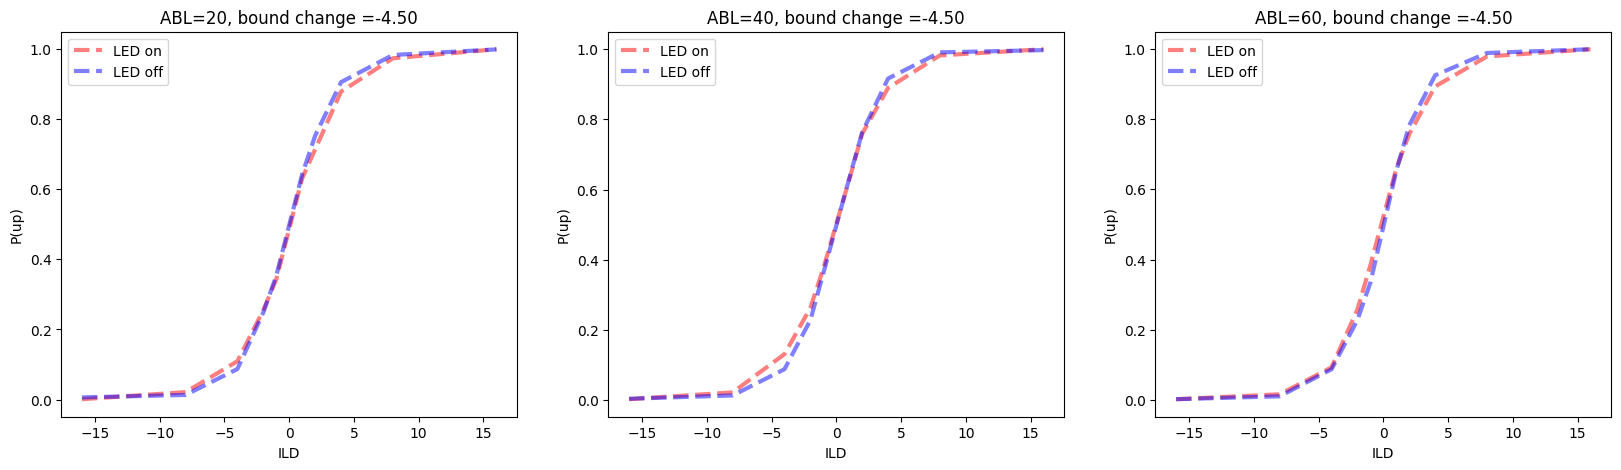

In [12]:
for i in range(0, N_params):
    # for each V_A
    each_bound_results = bound_change_results_dict[i]['results']
    new_bound = bound_change_results_dict[i]['new_bound']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_bound_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL}, bound change ={new_bound - theta_E:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');

# chronometric w./o aborts

## real dataa

In [13]:
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

## sim data

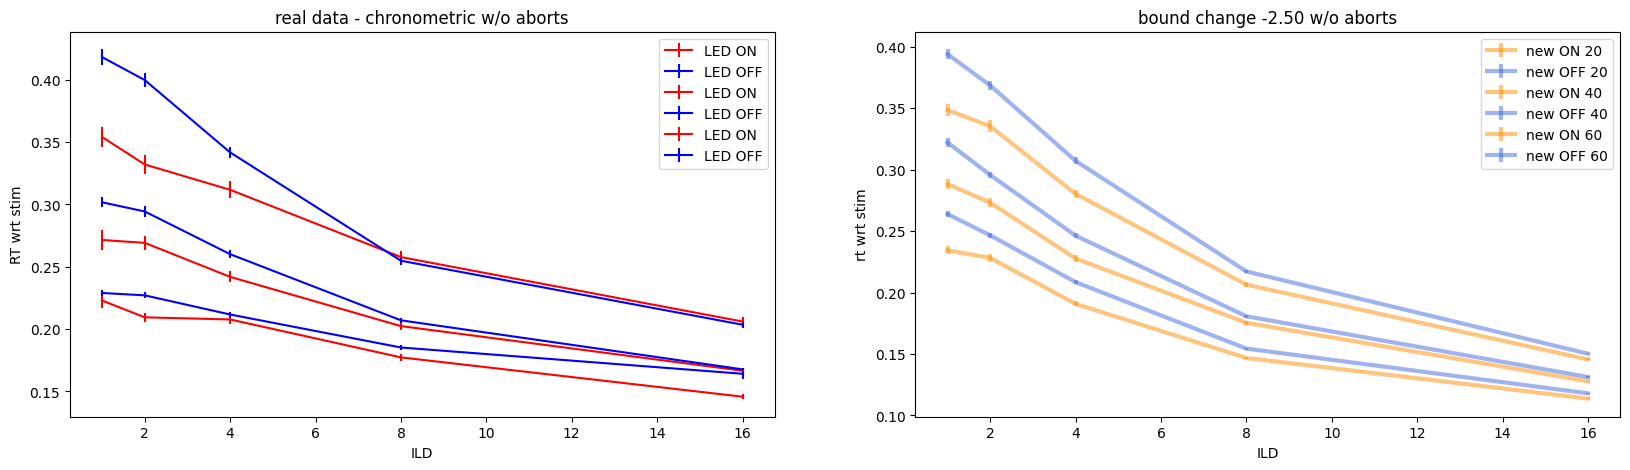

In [16]:
base_bound_data = bound_change_results_dict[0]['results']


# change V_A
new_bound_idx = 5
new_bound_value = bound_change_results_dict[new_bound_idx]['new_bound']
new_bound_data = bound_change_results_dict[new_bound_idx]['results']

# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

#  base
for res in base_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_bound_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led'] and res['rt'] > res['t_stim']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])


# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))

# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')

plt.subplot(1,2,2)
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'bound change {(new_bound_value - theta_E):.2f} w/o aborts')